In [5]:
import pandas as pd

# 加载交通事故数据
traffic_data = pd.read_excel('TrafficAccident_22.xlsx', sheet_name=None)

# 获取所有的工作表
accident_data = traffic_data['Sheet1']  # 假设数据在Sheet1中

# 只保留有用列（大区ID，小区ID，barrio名称和交通事故率列）
accident_data = accident_data[['COD_DIS', 'COD_BAR'] + [col for col in accident_data.columns if '_rate' in col]]

# 确保日期列的格式正确，去掉日期中的日部分
accident_data = accident_data.melt(id_vars=['COD_DIS', 'COD_BAR'], 
                                   var_name='Date', value_name='accident_rate_melted')

# 格式化日期列（从YYYYMM_rate转为日期格式，并去掉日部分）
accident_data['Date'] = pd.to_datetime(accident_data['Date'].str[:6], format='%Y%m')

# 只保留年月（YYYY-MM）格式
accident_data['Date'] = accident_data['Date'].dt.to_period('M')

# 加载社会因子数据
social_data = pd.read_excel('CONTROL_ADD.xlsx', sheet_name=None)

# 合并所有社会因子数据工作表，去除重复列
social_factors = pd.DataFrame()
for sheet_name, sheet_data in social_data.items():
    # 只保留有用列
    relevant_columns = ['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'] + [col for col in sheet_data.columns if '20' in str(col)]
    sheet_data = sheet_data[relevant_columns]
    
    # 确保日期列的格式正确，去掉日期中的日部分
    sheet_data = sheet_data.melt(id_vars=['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'],
                                 var_name='Date', value_name=sheet_name.lower())
    sheet_data['Date'] = pd.to_datetime(sheet_data['Date'].str.extract(r'(\d{4}_\d{2})')[0], format='%Y_%m')
    
    # 只保留年月（YYYY-MM）格式
    sheet_data['Date'] = sheet_data['Date'].dt.to_period('M')
    
    # 合并到social_factors，去除重复的 NOMBRE_BAR 列
    if social_factors.empty:
        social_factors = sheet_data
    else:
        social_factors = pd.merge(social_factors, sheet_data.drop(columns=['NOMBRE_BAR']), on=['COD_DIS', 'COD_BAR', 'Date'], how='outer')

# 合并所有数据
merged_data = pd.merge(accident_data, social_factors, on=['COD_DIS', 'COD_BAR', 'Date'], how='left')

# 打印合并后的数据
print(merged_data.head())



   COD_DIS  COD_BAR     Date  accident_rate_melted NOMBRE_BAR  education  \
0        2       21  2018-01                  3.94   Imperial  67.002450   
1        2       22  2018-01                  5.42    Acacias  67.760715   
2        2       23  2018-01                 14.47    Chopera  54.548206   
3        2       24  2018-01                  0.00    Legazpi  76.241384   
4        2       25  2018-01                 13.34   Delicias  65.224026   

   income    population  transport  commercial  residential  roadvolume  
0  23.373  23584.276797  40.272578   46.503043    26.213600  729.953737  
1  23.373  34382.052976  36.304673  136.011590    33.912998  471.049514  
2  23.373  35309.044811  40.477703  170.838854    31.666700  578.407108  
3  23.373  13908.384829  17.661121   24.744242    17.880800  717.284370  
4  23.373  26301.837628  19.896309   96.711876    33.035702  331.355592  


In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 假设数据已经加载到 merged_data 中
# 确保 COD_BAR 列为字符串类型
merged_data['COD_BAR'] = merged_data['COD_BAR'].astype(str).str.zfill(3)  # 填充为三位数

# 创建 `treatment` 列：假设 COD_BAR 完全等于 '011', '012', '013', '014', '015', '016' 为处理组
mapping = {
    '021': 21, '022': 22, '023': 23, '024': 24, '025': 25, '026': 26, '027': 27,
    '031': 31, '032': 32, '033': 33, '034': 34, '035': 35, '036': 36,
    '041': 41, '042': 42, '043': 43, '044': 44, '045': 45, '046': 46,
    '051': 51, '052': 52, '053': 53, '054': 54, '055': 55, '056': 56,
    '061': 61, '062': 62, '063': 63, '064': 64, '065': 65, '066': 66,
    '071': 71, '072': 72, '073': 73, '074': 74, '075': 75, '076': 76
}

# 根据映射字典为 treatment 列赋值
merged_data['treatment'] = merged_data['COD_BAR'].map(mapping).fillna(0).astype(int)

# 创建 Date_num 列（年月数值表示）
merged_data['Date_num'] = merged_data['Date'].dt.year * 100 + merged_data['Date'].dt.month

# 确保 `Date_num` 列为整数类型（如果它还不是整数）
merged_data['Date_num'] = merged_data['Date_num'].astype(int)

# 创建时间虚拟变量：政策前后的月份
months_before = [202108, 202109, 202110, 202111, 202112]  # 政策前
months_after = [202201,202202, 202203, 202204, 202205, 202206]   # 政策后

# 创建 policy_month 列，表示每个时间点是否为政策前或政策后
merged_data['policy_month'] = np.nan
merged_data.loc[merged_data['Date_num'].isin(months_before), 'policy_month'] = 'pre'
merged_data.loc[merged_data['Date_num'].isin(months_after), 'policy_month'] = 'post'

# 创建交互项：处理组在不同月份的变化（使用 policy_month 和 treatment 的交互项）
for month in months_before:
    merged_data[f'treatment_pre_{month}'] = merged_data['treatment'] * (merged_data['Date_num'] == month)

for month in months_after:
    merged_data[f'treatment_post_{month}'] = merged_data['treatment'] * (merged_data['Date_num'] == month)

# 检查是否成功创建交互项列
print(merged_data.columns)

# 回归模型：包括交互项（treatment * pre 和 treatment * post），时间固定效应和地区固定效应
# 假设控制变量名称已变为小写，并且存在
formula = 'accident_rate_melted ~ ' + ' + '.join([f'treatment_pre_{month}' for month in months_before]) + ' + ' + ' + '.join([f'treatment_post_{month}' for month in months_after]) + ' + education + income + population + transport + commercial + residential  + C(COD_BAR) + C(Date_num)'

# 执行回归
model = smf.ols(formula=formula, data=merged_data).fit()

# 打印回归结果
print(model.summary())




C:\Users\czy01\AppData\Local\Temp\ipykernel_21664\2875727813.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[merged_data['Date_num'].isin(months_before), 'policy_month'] = 'pre'


Index(['COD_DIS', 'COD_BAR', 'Date', 'accident_rate_melted', 'NOMBRE_BAR',
       'education', 'income', 'population', 'transport', 'commercial',
       'residential', 'roadvolume', 'treatment', 'Date_num', 'policy_month',
       'treatment_pre_202108', 'treatment_pre_202109', 'treatment_pre_202110',
       'treatment_pre_202111', 'treatment_pre_202112', 'treatment_post_202202',
       'treatment_post_202203', 'treatment_post_202204',
       'treatment_post_202205', 'treatment_post_202206',
       'treatment_post_202201'],
      dtype='object')
                             OLS Regression Results                             
Dep. Variable:     accident_rate_melted   R-squared:                       0.689
Model:                              OLS   Adj. R-squared:                  0.681
Method:                   Least Squares   F-statistic:                     81.35
Date:                  Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                          12:43:16   Lo

In [9]:
import statsmodels.formula.api as smf

regression_results_df = pd.DataFrame(model.params, columns=['Coefficient'])
regression_results_df['Std Err'] = model.bse
regression_results_df['t-Statistic'] = model.tvalues
regression_results_df['P-Value'] = model.pvalues

# 保存回归结果为CSV文件
csv_file_path = 'regression_results2022.csv'
regression_results_df.to_csv(csv_file_path)

# 返回保存的CSV文件路径
csv_file_path

'regression_results2022.csv'

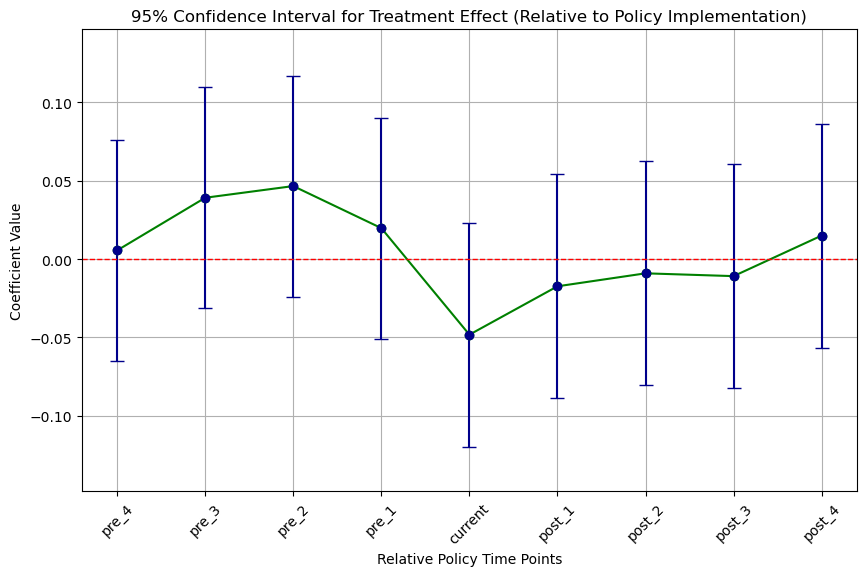

In [11]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

regression_result2022 = pd.read_csv('regression_result2022.csv')


# 提取系数的日期和数值
months = [ '202109','202110', '202111', '202112', '202201','202202', '202203', '202204', '202205']
coef_values = regression_result2022['Coefficient'].values  # 获取回归系数
std_errors = regression_result2022['Std Err'].values

coef_values = np.array(coef_values, dtype=float)
std_errors = np.array(std_errors, dtype=float)

# 假设标准误为系数的±10%（实际中应根据数据提供）
# 计算95%置信区间
z_value = 1.96  # 95%置信区间的Z值
conf_values = [(coef - z_value * std, coef + z_value * std) for coef, std in zip(coef_values, std_errors)]

# 相对政策的月份，"current"是政策实施月份
time_labels = ['pre_4','pre_3', 'pre_2', 'pre_1', 'current', 'post_1', 'post_2', 'post_3', 'post_4']  # 用于横轴标签
if len(time_labels) != len(coef_values):
    raise ValueError("The length of time_labels does not match the length of coef_values")
# 绘制置信区间图
plt.figure(figsize=(10, 6))

# 绘制系数和置信区间
plt.errorbar(time_labels, coef_values, 
             yerr=[[coef_values[i] - conf_values[i][0] for i in range(len(months))], 
                   [conf_values[i][1] - coef_values[i] for i in range(len(months))]],
             fmt='o', capsize=5, color='darkblue',label='Coefficient with 95% CI')

plt.plot(time_labels, coef_values, linestyle='-', color='green', marker='o', label='Trend Line')

plt.axhline(0, color='red', linestyle='--', linewidth=1)
# 添加标题和标签
plt.title('95% Confidence Interval for Treatment Effect (Relative to Policy Implementation)')
plt.xlabel('Relative Policy Time Points')
plt.ylabel('Coefficient Value')

# 调整纵轴范围，确保纵轴的每个单位跨度为2
plt.ylim(min(coef_values) - 0.1, max(coef_values) + 0.1)  # 拉大纵轴范围

# 旋转X轴标签
plt.xticks(rotation=45)

# 显示网格和紧凑布局
plt.grid(True)


# 显示图表
plt.show()



